In [8]:
suppressPackageStartupMessages({
  library(dplyr)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(pagoda2)
  library(ggrepel)
  library(data.table)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
all_markers <- load_markers_pancreas(filter_markers=FALSE)

all_markers_list <- lapply(unique(all_markers$marker_of),function(x){
  return(all_markers$gene[all_markers$marker_of==x])
})
names(all_markers_list) <- unique(all_markers$marker_of)

In [3]:
# load counts version of org and clean data
base_dir <- CachePath('pancreas_scaled_dat4/')
so_spatial_orig <- readRDS(file=paste0(base_dir,'so_spatial_orig.rds'))
so_spatial_cln <- readRDS(file=paste0(base_dir,'so_spatial_cln_15_full.rds'))

dat_orig <- so_spatial_orig[['RNA']]$counts
meta_orig <- so_spatial_orig@meta.data

dat_cln <- so_spatial_cln[['RNA']]$counts
meta_cln <- so_spatial_cln@meta.data

# subset data to same cells
cells_both <- intersect(colnames(dat_orig),colnames(dat_cln))
dat_orig <- dat_orig[,cells_both]
dat_cln <- dat_cln[,cells_both]
meta_orig <- meta_orig[cells_both,]

# append xy cell centroids
data <- prepare_pancreas_sc_spatial()
cell_annot <- data[[2]]
meta_orig <- cbind.data.frame(meta_orig,cell_annot[rownames(meta_orig),c('x','y')])

Normalizing layer: counts



In [4]:
head(meta_orig)

,orig.ident,nCount_RNA,nFeature_RNA,cell,cell_type,x,y
,<fct>,<dbl>,<int>,<chr>,<chr>,<dbl>,<dbl>
aaacalai-1,SeuratProject,67,32,aaacalai-1,tumor,441.3078,1735.878
aaacjgil-1,SeuratProject,66,36,aaacjgil-1,tumor,466.0532,1712.260
aaadhocp-1,SeuratProject,159,60,aaadhocp-1,tumor,476.1111,1711.089
aaadpbhl-1,SeuratProject,99,40,aaadpbhl-1,tumor,490.0821,1717.446
aaafbala-1,SeuratProject,75,37,aaafbala-1,tumor,490.2920,1709.011
aaagannb-1,SeuratProject,87,40,aaagannb-1,tumor,499.5687,1710.915


In [9]:
xn = meta_orig %>% select(x, y) %>% FNN::get.knn(k = 5) %>% .$nn.index
ct_dict = meta_orig %>% mutate(id = 1:n()) %>% {setNames(.$cell_type, .$id)}
cell_dict = meta_orig %>% mutate(id = 1:n()) %>% {setNames(.$cell, .$id)}
nmat = apply(xn, 2, function(i){ct_dict[i]})

ct_counts = nmat %>%
  reshape2::melt() %>%
  select(id = Var1, ct = value) %>%
  mutate(
    cell = cell_dict[id]
  ) %>%
  select(-id) %>%
  as.data.table %>%
  mutate(ct = paste0('n_', ct)) %>%
  dplyr::count(cell, ct, .drop = T) %>%
  dcast(cell ~ ct, value.var = 'n', fill = 0)

ct_counts <- as.data.frame(ct_counts)
rownames(ct_counts) <- ct_counts$cell
ct_counts$cell <- NULL

cells_keep <- meta_orig$cell[meta_orig$cell_type=='Endothelial']

dat_orig <- dat_orig[,cells_keep]
meta_orig <- meta_orig[cells_keep,]
dat_cln <- dat_cln[,cells_keep]
meta_cln <- meta_orig

meta_orig$stel_adj <- ct_counts[rownames(meta_orig),'n_Stellate']>0
meta_orig$stel_adj <- factor(meta_orig$stel_adj,levels=c(TRUE,FALSE))
levels(meta_orig$stel_adj) <- c('Near','Not near')

# # running de for original data
dat_pgda_orig <- basicP2proc(dat_orig, n.cores=1, min.cells.per.gene=0,min.transcripts.per.cell = 20,
                             n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_orig$stel_adj
names(regions_compare) <- rownames(meta_orig)
de_out_orig <- dat_pgda_orig$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                                  upregulated.only=FALSE,append.auc = TRUE)
de_out_orig <- de_out_orig[['Near']]

1470 cells, 377 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

4 overdispersed genes ... 4

persisting ... 

done.

running PCA using 377 OD genes .

.

.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 367 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


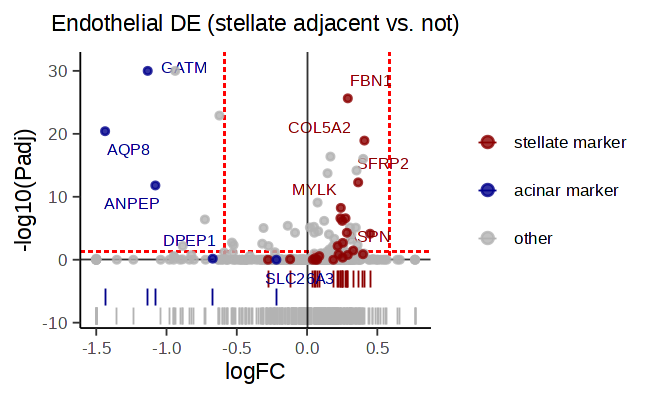

In [10]:
# make volcano plot
options(repr.plot.width = 3.25, repr.plot.height = 2, repr.plot.res = 200)
de_out_orig$padj <- 2*pnorm(abs(de_out_orig$Z), mean = 0, sd = 1, lower.tail = FALSE) # convert z back to padj
de_out_orig$mark_other <- sapply(de_out_orig$Gene,function(x){
  if (x %in% all_markers_list[['Stellate']]) {
    return('stellate marker')
  } else if (x %in% all_markers_list[['Acinar']]) {
    return('acinar marker')
  } else {
    return('other')
  }
})
de_out_orig$logpv <- -log10(de_out_orig$padj)
de_out_orig$logpv[de_out_orig$logpv>30] <- 30
de_out_orig$M[de_out_orig$M<(-1.5)] <- -1.5
ymax <- max(de_out_orig$logpv,na.rm=TRUE)+3
myColors <- c('red4','blue4','grey70')

# Helper variables
limits <- range(de_out_orig$logpv,na.rm = TRUE,finite = TRUE)
step   <- diff(limits) * 0.1
size   <- 0.45 * step

de_out_orig$mark_other <- factor(de_out_orig$mark_other,levels=c('stellate marker','acinar marker','other'))
bottom_lim <- min(limits[1] - as.numeric(de_out_orig$mark_other) * step - size) - .5

de_out_orig <- de_out_orig[order(de_out_orig$Z,decreasing=TRUE),]
de_out_orig_flip <- de_out_orig[order(de_out_orig$Z,decreasing=FALSE),]

g1 <- de_out_orig$Gene[de_out_orig$mark_other=='stellate marker'][1:5]
g2 <- de_out_orig_flip$Gene[de_out_orig_flip$mark_other=='acinar marker'][1:5]
g_lab <- c(g1,g2)
de_out_orig$top_mark_other <- NA
de_out_orig[de_out_orig$Gene%in%g_lab,'top_mark_other'] <- de_out_orig$Gene[de_out_orig$Gene%in%g_lab]

p <- ggplot(de_out_orig,aes(x=M,y=logpv,color=mark_other,label=top_mark_other)) +
  geom_segment(aes(y=ymax,yend=0,x = log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(aes(y=ymax,yend=0,x = -log2(1.5)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_hline(yintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_segment(aes(x=-Inf,xend=Inf,y = -log10(.05)),color='red',linetype='dashed',alpha=gg_line_alpha,linewidth=3*gg_line_thickness/4) +
  geom_segment(
    aes(
      color = mark_other,
      xend = M,
      y    = limits[1] - as.numeric(mark_other) * step + size,
      yend = limits[1] - as.numeric(mark_other) * step - size
    ),
      linewidth=gg_line_thickness
  ) +
  geom_text_repel(size=geom_text_size, family=font_choice, show.legend = FALSE) +
  geom_vline(xintercept=0,linewidth=gg_line_thickness,alpha=gg_line_alpha) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='stellate marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=de_out_orig[de_out_orig$mark_other=='acinar marker',],alpha=gg_point_alpha,size=gg_point_size) +
  scale_y_continuous(limits=c(bottom_lim,ymax),expand = c(0, 0)) +
  xlab('logFC') +
  ylab('-log10(Padj)') +
  ggtitle('Endothelial DE (stellate adjacent vs. not)') +
  scale_colour_manual(breaks = c('stellate marker','acinar marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [11]:
pdf(OutputPath("pancreas_endo_de.pdf"), useDingbats=FALSE, width=3.25, height=2)
p
dev.off()

Warning message:
“Removed 367 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2

In [13]:
## run fgsea
mystats <- de_out_orig$M
names(mystats) <- rownames(de_out_orig)
mystats <- mystats[!is.nan(mystats)]
mystats <- mystats[is.finite(mystats)]
# set_list <- list(admix_markers)
# names(set_list) <- c('stellate_markers')
set_list <- all_markers_list
fgsea_res <- fgsea::fgseaSimple(
  pathways = set_list, stats = mystats, minSize=5, nperm=10000
)
print(head(fgsea_res))

Warning message in preparePathwaysAndStats(pathways, stats, minSize, maxSize, gseaParam, :
“There are ties in the preranked stats (2.39% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


                  pathway        pval        padj         ES        NES
                   <char>       <num>       <num>      <num>      <num>
1:               Stellate 0.001310616 0.006553080  0.6312382  2.1477415
2:            Endothelial 0.905249344 0.905249344 -0.2478873 -0.6460381
3: Alpha-Beta-Delta-Gamma 0.021606318 0.036010530 -0.7078221 -1.5882447
4:             Macrophage 0.833169291 0.905249344  0.2147513  0.7672555
5:                 Acinar 0.003333333 0.008333333 -0.8873900 -1.6433763
   nMoreExtreme  size  leadingEdge
          <num> <int>       <list>
1:            2    24 THBS2, C....
2:         6897    22 CA4, SOX....
3:          144    11 INS, CHG....
4:         1692    28 VCAN, CX....
5:           18     5 AQP8, GA....


In [14]:
## run de for cleaned data
meta_cln$stel_adj <- meta_orig$stel_adj
dat_pgda_cln <- basicP2proc(dat_cln, n.cores=1, min.cells.per.gene=0,min.transcripts.per.cell = 20,
                             n.odgenes=2e3, get.largevis=FALSE, make.geneknn=FALSE)
regions_compare <- meta_cln$stel_adj
names(regions_compare) <- rownames(meta_cln)
de_out_cln <- dat_pgda_cln$getDifferentialGenes(verbose=TRUE,groups=regions_compare,z.threshold = 0,
                                                  upregulated.only=FALSE,append.auc = TRUE)
de_out_cln <- de_out_cln[['Near']]

# order genes the same in both de results matrixes
de_out_orig <- de_out_orig[rownames(de_out_cln),]

1463 cells, 377 genes; normalizing ... 

Using plain model 

Winsorizing ... 

log scale ... 

done.


calculating variance fit ...

 using gam 

4 overdispersed genes ... 4

persisting ... 

done.

running PCA using 377 OD genes .

.



.

.

 done




creating space of type angular done
adding data ... done
building index ... done
querying ... done


running tSNE using 1 cores:


running differential expression with 2 clusters ... 

adjusting p-values ... 

done.




Warning message:
“Removed 367 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


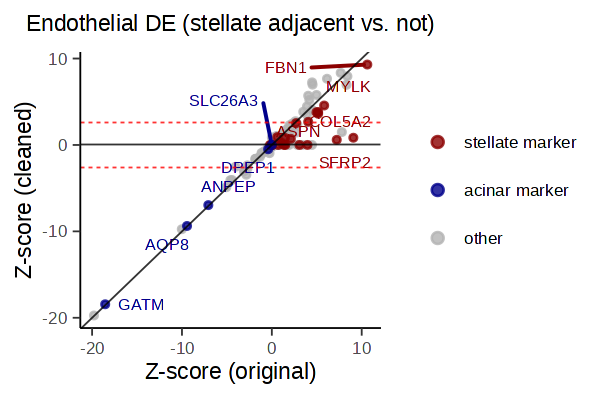

In [15]:
options(repr.plot.width = 3, repr.plot.height = 2, repr.plot.res = 200)

#### plot DE comparison
z_thresh <- qnorm(.01/2,lower.tail = FALSE)
tmp <- cbind.data.frame(de_out_orig[,'Z'],de_out_cln[,'Z'])
colnames(tmp) <- c('orig','clean')
rownames(tmp) <- rownames(de_out_orig)

## trying to color points by tumor marker set belonging
tmp$markers <- sapply(rownames(tmp),function(x){
  if (x %in% all_markers_list[['Stellate']]) {
    return('stellate marker')
  } else if (x %in% all_markers_list[['Acinar']]) {
    return('acinar marker')
  } else {
    return('other')
  }
})
ndx_lab <- match(g_lab,rownames(tmp))
g_lab <- g_lab[!is.na(ndx_lab)]
ndx_lab <- ndx_lab[!is.na(ndx_lab)]
tmp$glab <- NA
tmp[ndx_lab,'glab'] <- g_lab
z_upper_thresh <- 20
tmp[which(tmp$orig>z_upper_thresh),'orig'] <- z_upper_thresh
tmp[which(tmp$orig<(-z_upper_thresh)),'orig'] <- -z_upper_thresh
tmp[which(tmp$clean>z_upper_thresh),'clean'] <- z_upper_thresh
tmp[which(tmp$clean<(-z_upper_thresh)),'clean'] <- -z_upper_thresh
tmp$markers <- factor(tmp$markers,levels=c('stellate marker','acinar marker','other'))
myColors <- c('red4','blue4','grey70')
p <- ggplot(tmp,aes(x=orig,y=clean,color=markers,label=glab)) +
  geom_point(data=tmp[tmp$markers=='other',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='stellate marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_point(data=tmp[tmp$markers=='acinar marker',],alpha=gg_point_alpha,size=gg_point_size) +
  geom_text_repel(size=geom_text_size,show.legend = FALSE,family=font_choice) +
  ggtitle('Endothelial DE (stellate adjacent vs. not)') +
  xlab('Z-score (original)') +
  ylab('Z-score (cleaned)') +
  geom_hline(linewidth=gg_line_thickness, yintercept = z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness, yintercept = -1*z_thresh,color='red',linetype='dashed',alpha=gg_line_alpha) +
  geom_hline(linewidth=gg_line_thickness, yintercept = 0,alpha=gg_line_alpha) +
  geom_abline(linewidth=gg_line_thickness, slope = 1,intercept=0,alpha=gg_line_alpha) +
  scale_colour_manual(breaks = c('stellate marker','acinar marker','other'), values = myColors) +
  theme_classic(base_line_size = gg_line_thickness) +
  p_theme +
  theme(plot.title = element_text(hjust = 0.5),
       legend.title=element_blank()) +
  legend_mod

p

In [16]:
pdf(OutputPath("pancreas_de_pre_post.pdf"), useDingbats=FALSE, width=3, height=2)
p
dev.off()

Warning message:
“Removed 367 rows containing missing values or values outside the scale range
(`geom_text_repel()`).”


png 
  2